In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

import datetime
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
today = datetime.date.today()

In [3]:
data = yf.download('GOOGL', start='2010-01-01', end=today)
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2010-01-04,15.609805,15.678546,15.547292,15.614786,78169752
2010-01-05,15.541063,15.636952,15.480044,15.620514,120067812
2010-01-06,15.149294,15.587638,15.101973,15.587638,158988852
2010-01-07,14.796625,15.192631,14.760512,15.177686,256315428
2010-01-08,14.993881,15.024515,14.672344,14.744323,188783028


In [ ]:
df = data[['Close']]

dataset = df.values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i+look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # last 60 days to predict next day
X, y = create_dataset(scaled_data, look_back)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',)

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

c:\Users\PMYLS\Downloads\Machine-Learning-Projects\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 0.0077 - val_loss: 9.6903e-04
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 6.7979e-04 - val_loss: 0.0029
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.6598e-04 - val_loss: 9.2627e-04
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 6.0545e-04 - val_loss: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.4756e-04 - val_loss: 8.9531e-04
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 5.7780e-04 - val_loss: 0.0013
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 4.6339e-04 - val_loss: 8.9657e-04
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.1331e-04 - val_loss: 0.0022
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 5.4834e-04 - val_loss: 9.2303e-04
Epoch 10/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.2614e-04 - val_loss: 7.1878e-04
Epoch 11/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 4.0387e-04 - val_loss: 0.001

120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step


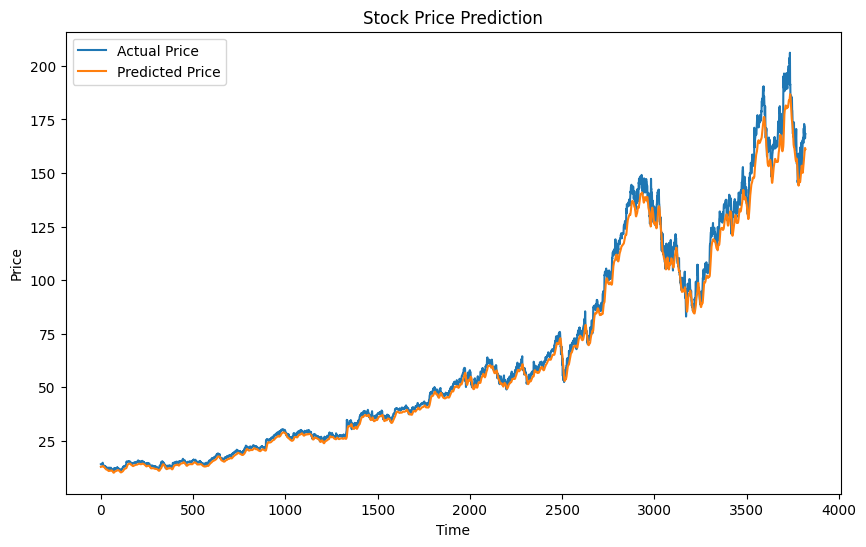

In [ ]:
train_predict = model.predict(X)

train_predict = scaler.inverse_transform(train_predict)
actual = scaler.inverse_transform([y])

plt.figure(figsize=(10,6))
plt.plot(actual[0], label='Actual Price')
plt.plot(train_predict[:,0], label='Predicted Price')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [8]:
last_60_days = scaled_data[-look_back:]
next_input = last_60_days.reshape(1, look_back, 1)
next_price = model.predict(next_input)
print("Tomorrow's Predicted Price:", scaler.inverse_transform(next_price)[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tomorrow's Predicted Price: 160.86084


In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Test MSE: 70.0941
Test R^2 Score: 0.9261
